In [402]:
from imprint.nb_util import setup_nb

# setup_nb is a handy function for setting up some nice plotting defaults.
setup_nb()
import scipy.stats
import matplotlib.pyplot as plt

import imprint as ip
import numpy as np
import jax


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [406]:
grid = ip.cartesian_grid(
        [-3, -3], [3, 3], n=[10, 10], prune=True, null_hypos=[ip.hypo("theta0 < "+str(logit(0.5))), ip.hypo("theta1 <" +str(logit(0.7)))]
    )
lam = 0.025
x = expit(grid.df["theta0"] - grid.df["radii0"])*0.4 + 0.6*expit(grid.df["theta1"] - grid.df["radii1"]) < 0.5*0.4 + 0.7*0.6
grid.df["null_truth2"] = x
type(grid.df)
#plt.scatter(grid.df["theta0"], grid.df["theta1"], c = grid.df["null_truth2"])

pandas.core.frame.DataFrame

,id,active,parent_id,theta0,theta1,radii0,radii1,null_truth0
0,4390542138086260736,False,0,-2.85,-2.85,0.15,0.15,True
1,4390542138086260737,True,0,-2.55,-2.85,0.15,0.15,True
2,4390542138086260738,True,0,-2.25,-2.85,0.15,0.15,True
3,4390542138086260739,True,0,-1.95,-2.85,0.15,0.15,True
4,4390542138086260740,True,0,-1.65,-2.85,0.15,0.15,True
...,...,...,...,...,...,...,...,...
225,4390542206805737502,True,4390542138086261051,1.65,1.65,0.15,0.15,True
226,4390542206805737504,True,4390542138086261072,1.95,1.95,0.15,0.15,True
227,4390542206805737506,True,4390542138086261093,2.25,2.25,0.15,0.15,True
228,4390542206805737508,True,4390542138086261114,2.55,2.55,0.15,0.15,True


In [390]:
#First building a function which operates on a single grid point
def closed_test(pvalues, alpha):
    rejected = [False]*len(pvalues)
    for i in range(len(pvalues)):
        curr_rejections = sum(rejected)
        curr_thresh = alpha/(len(pvalues)-sum(rejected))
        rejected = [rejected[i] or pvalues[i] <= curr_thresh for i in range(len(pvalues))]
        if sum(rejected) == len(pvalues):
            break
    return  rejected

In [391]:
#Next, we simultaneously operate on all of the grid-points, and return a list of rejections
def closed_test_half(pvalues, alpha):
    #initialize rejections to false, with shape = shape(pvalues)
    rejected = full_like(pvalues, False)
    for i in range(shape(pvalues)[1]):
        sumrejections = np.sum(rejected,axis=1)
        curr_thresh = alpha/(shape(pvalues)[1]-sumrejections)
        rejected = rejected or pvalues <= curr_thresh[:,None]
        print(rejected)
    return  rejected

In [392]:
def closed_test_full(pvalues, alpha):
    #initialize rejections to false,
    #will have shape = (#criticalvalues, #hypotheses, #gridpoints, #sims)
    temp = pvalues[None,:,:,:]+alpha[:,None,:,:]
    #temp.shape is (10, 3, 360, 100)
    rejected = np.full_like(temp, False) 
    # alpha.shape is 10, 360, 100
    epsilon = 1e-10
    for i in range(pvalues.shape[0]):
        sumrejections = np.sum(rejected,axis=1)
        curr_thresh = alpha/(epsilon+pvalues.shape[0]-sumrejections)
        rejected = np.less_equal(pvalues[None,:,:,:], curr_thresh[:,None,:,:])
    return  rejected

In [399]:
class BinomialClosed:
    def __init__(self, seed, max_K, *, n):
        self.family = "binomial"
        self.family_params = {"n": n[0]}
        self.n=n
        key = jax.random.PRNGKey(seed)
        splitkeys = jax.random.split(key, num=2)
        self.samples_arm1 = jax.random.uniform(
            splitkeys[1], shape=(max_K, n[1]), dtype=np.float32
        )
        
        self.samples_arm0 = jax.random.uniform(
            splitkeys[0], shape=(max_K, n[0]), dtype=np.float32
        )

    def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
        p = expit(theta)
        # successes is a 2-dimensional array of shape: (n_tiles, n_sims = K)
        successes1 = np.sum(self.samples_arm1[None, begin_sim:end_sim, :] < p[:, None, None, 1],axis =2)
        successes0 = np.sum(self.samples_arm0[None, begin_sim:end_sim, :] < p[:, None, None, 0],axis =2)
        phat1 = successes1 / self.n[1]
        phat0 = successes0 / self.n[0]
        #pooledphat = (phat1*self.n[1] + phat0*self.n[0]) / (self.n[1] + self.n[0])
        zstat0 = (phat0 - 0.5) / np.sqrt(phat0 * (1 - phat0) / self.n[0])
        zstat1 = (phat1 - 0.7)/ np.sqrt(phat1 * (1 - phat1) / self.n[1])
        zstatcombo = (0.4 * (phat0 -0.5)+ 0.6* (phat1- 0.7)) / np.sqrt( 0.4**2 * phat0*(1-phat0)/ self.n[0] + 0.6**2 * phat1*(1-phat1)/ self.n[1])
        pvalues = 1-scipy.stats.norm.cdf([zstat0,zstat1,zstatcombo])
        pvalues = np.nan_to_num(pvalues) + ([phat0,phat1,phat1 * phat0] == np.full_like(pvalues,0))
        # The following needs to be vectorized
        possible_critical_values = np.sort(np.concatenate((pvalues,2*pvalues,3*pvalues,np.full_like(pvalues[1,:,:],100)[None,:,:])))
        #next we need to apply closed testing to the 3 pvalues for EVERY choice in the list of possible critical values
        rejections_list = closed_test_full(pvalues, possible_critical_values)
        #dimensions of rejections_list = (#gridpoints, #hypotheses, #criticalvalues = hypotheses^2)
        nullstatus = np.asarray(np.transpose(null_truth))
        falserejs = np.logical_and(rejections_list,nullstatus[None,:,:,None])
        fwer = np.any(falserejs, axis = 1)
        #some akwardness to cause the following minimum to give us the right answer
        temp = 1000*(1 - fwer) + fwer*possible_critical_values
        out = np.min(temp, axis=0)
        #out.shape : n_tiles, n_sims
        return out


In [405]:
x=BinomialClosed(0, 2, n = [100,100])
outs = x.sim_batch(0, 2, theta = grid.get_theta(), null_truth=grid.df[["null_truth0", "null_truth1", "null_truth2"]])


In [424]:
grid = ip.cartesian_grid(
        [-0.5, -0.5], [1.5, 1.5], n=[100, 100], prune=True, null_hypos=[ip.hypo("theta0 < "+str(logit(0.5))), ip.hypo("theta1 <" +str(logit(0.7)))]
    )
lam = 0.025
x = expit(grid.df["theta0"] - grid.df["radii0"])*0.4 + 0.6*expit(grid.df["theta1"] - grid.df["radii1"]) < 0.5*0.4 + 0.7*0.6
grid.df["null_truth2"] = x
type(grid.df)
y = ip.validate(BinomialClosed, grid, 0.025, K=10000, model_kwargs=dict(n=[100,100]))

In [425]:
y.shape

(7650, 4)

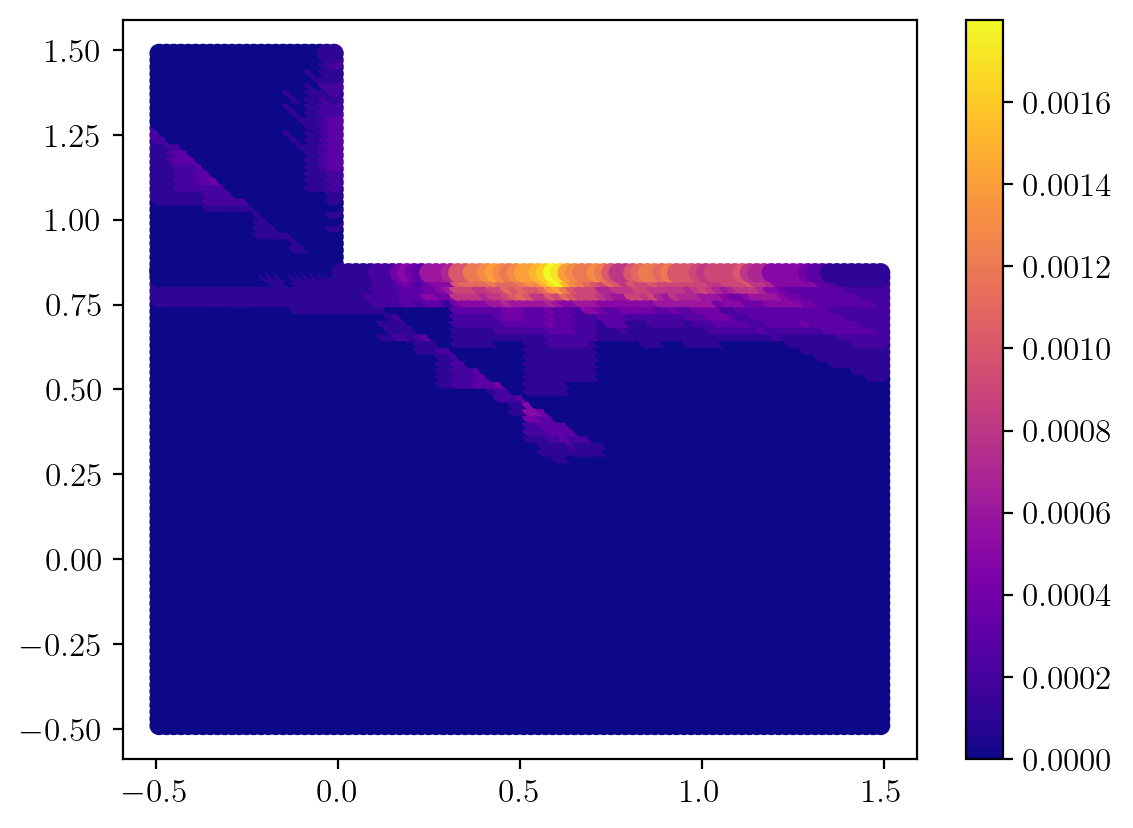

In [426]:
plt.scatter(grid.df["theta0"], grid.df["theta1"], c=y["tie_est"])
plt.colorbar()